 # Predicting Today's Temperature | Final Project CSC 570 Fall 2016
 ## Matthew T. Dearing

The weather is a tricky thing. At a minimum, it can be described as a complex fluid dynamical system. Humans have long tried to figure out what the weather will do in the future, and even today it takes the latest supercomputing technology just to visualize atmospheric fluid flows extrapolated out to only the very near future.

Our planet’s weather affects everyone on a daily basis from the seemingly trivial question, “What’s the weather like today?” Throw in some social and political pressure and the climate change war horns, and the topic of understanding the weather expectations quickly becomes a vital pursuit of the atmospheric research community. (http://www.alcf.anl.gov/publications/modeling-high-impact-weather-and-climate-lessons-tropical-cyclone-perspective)

What if we could just take some historical weather data and make a reasonable prediction of what tomorrow will be like? Or, any day this year? After appreciating the continued intense effort of meteorologists and climatologist, this remains a pie-in-the-sky dream.

But, how close to reasonable year-long predictions can we get with minimal data?

Here, we explore the historical daily summary weather data provided through the National Oceanic and Atmospheric Administration’s (NOAA) Global Historical Climate Network. (https://www.ncdc.noaa.gov/cdo-web/datasets) This publically-available collection contains a variety of basic weather measurements including daily minimum and maximum temperatures, precipitation and even snow fall from over 25,000 weather stations around the world. (http://www1.ncdc.noaa.gov/pub/data/metadata/images/C00861_GHCN-D_stations.png)

First, we take a deep dive into the data set of daily summaries in over 1,000 data files containing over 10 million records. Then, we hone in on a particular available data set that includes manual cloud cover observations to create a model of predicting the maximum daily temperature for any day of the year… and see how good (or not so good) we can get.

NOTE: I've included some of my experimentation, which is labelled as # code test: -- not for presentation, rather for reference to some background trial-and-error.

In [2]:
import os
import csv
import re
import pandas as pd
import numpy as np

A lising of all files available from the GHCN-Daily data set. Each file represents a single weather station with collected data over all time (some go back to early 1900s!):

In [2]:
path = 'ghcnd_all.tar/ghcnd_all/'
listing = os.listdir(path)
for infile in listing:
    print path + infile

ghcnd_all.tar/ghcnd_all/AGM00060515.dly
ghcnd_all.tar/ghcnd_all/AGM00060670.dly
ghcnd_all.tar/ghcnd_all/AJ000037962.dly
ghcnd_all.tar/ghcnd_all/ALE00100939.dly
ghcnd_all.tar/ghcnd_all/AM000037954.dly
ghcnd_all.tar/ghcnd_all/AM000037959.dly
ghcnd_all.tar/ghcnd_all/ARM00087548.dly
ghcnd_all.tar/ghcnd_all/ASM00094299.dly
ghcnd_all.tar/ghcnd_all/ASN00002007.dly
ghcnd_all.tar/ghcnd_all/ASN00004026.dly
ghcnd_all.tar/ghcnd_all/ASN00004045.dly
ghcnd_all.tar/ghcnd_all/ASN00005041.dly
ghcnd_all.tar/ghcnd_all/ASN00008100.dly
ghcnd_all.tar/ghcnd_all/ASN00008114.dly
ghcnd_all.tar/ghcnd_all/ASN00008146.dly
ghcnd_all.tar/ghcnd_all/ASN00008177.dly
ghcnd_all.tar/ghcnd_all/ASN00008251.dly
ghcnd_all.tar/ghcnd_all/ASN00008308.dly
ghcnd_all.tar/ghcnd_all/ASN00009086.dly
ghcnd_all.tar/ghcnd_all/ASN00009584.dly
ghcnd_all.tar/ghcnd_all/ASN00009698.dly
ghcnd_all.tar/ghcnd_all/ASN00009800.dly
ghcnd_all.tar/ghcnd_all/ASN00009801.dly
ghcnd_all.tar/ghcnd_all/ASN00009886.dly
ghcnd_all.tar/ghcnd_all/ASN00009933.dly


In [44]:
# code test: opening a single file
#datafile = open("data/AGM00060515.dly")

In [45]:
# code test: extracting the station name from the file name
#station = re.sub(".dly", "", datafile.name)
#station = re.sub("data/", "", station)

In [46]:
# code test:
#station

'AGM00060515'

In [47]:
# code test:
#datalines = list(open("data/AGM00060515.dly")) # list of strings

In [48]:
# code test: exploring how to extract the data from the string rows in each data file
## datalines[0]
# find the station ID -- store in array
# next 4 characters = year -- store in array
# next 2 characters = month -- store in array
# next 4 characters = data label -- store in array
# next '-' or INT characters = value -- store in array
# next character (including space) = flag -- store in array
# next character (including space) = flag -- store in array
# next character (including space) = flag -- store in array

'AGM00060515198403TMAX-9999     152  S-9999     195  S-9999   -9999   -9999   -9999   -9999     112  S-9999   -9999     166  S-9999     146  S-9999     170  S  226  S  245  S  210  S  185  S-9999   -9999   -9999     240  S  222  S  224  S  250  S  190  S  245  S  256  S\n'

In [257]:
# code test: getting the next line
#datalines[1]

'AGM00060515198403TMIN-9999      62  S-9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999   -9999      41  S   56  S   21  S   70  S-9999      80  S   81  S-9999      54  S   79  S-9999     134  S-9999   -9999   -9999     105  S-9999   \n'

In [190]:
# code test: output after figuring out how to extract all of the non-measurement data
#datavalues

'-9999     152  S-9999     195  S-9999   -9999   -9999   -9999   -9999     112  S-9999   -9999     166  S-9999     146  S-9999     170  S  226  S  245  S  210  S  185  S-9999   -9999   -9999     240  S  222  S  224  S  250  S  190  S  245  S  256  S\n'

Each measurement data file includes:
 the station code or name,
 the year and month of the measurements,
 the type of measurement,
 actual measurement with three subsequent "flags" for each day of the month

These flags might be empty or contain a single character. There are a wide variety of flags, most of them representing some detail about the measurement, including if the value was converted from another unit, what time period the measurement spanned, if there was a failure in some separate quality assurance check, or additional location or source information about the measurement. For this analysis, it was determined that the information from all available flags was not necessary, so only the numerical data measurements are extracted along with the "type" of measurement.

Also to note, the value of -9999 represents missing data, so it was replaced with 0.

The are nearly 40 different "types" of measurements recording across all the data sets, with the key "types" for this analysis being "TMAX" (maximum daily temperature), "TMIN" (minimum daily temperature), "PRCP" (preciptation level), "TAVG" (average daily temperature), and "ACSH" (average cloudiness from manual observations).

Since the main data files only contain a "key" value representing the station, we want to also include the geographic details of the station to include in the prediction model. This information is stored in a separate text file available from NOAA, and each row contains the same "key" value for the station, its latitude and longitude coordinates, its elevation, and a more descriptive name.

We extract this geographic information for the stations, and later merge this detail with each weather measurement so that geographic location is considered along with the date, type and value of the measurements.

In [3]:
# Load in the station location details into a dataframe to be used for merging into the master data set of measurements
stationdata = list(open("ghcnd-stations.txt")) # list of strings

In [4]:
# Take a look at one row of the station information
stationdata[0]

'ACW00011604  17.1167  -61.7833   10.1    ST JOHNS COOLIDGE FLD                       \n'

In [5]:
# Extract the station information into a list, to be converted to a dataframe:
stationGeography = []
for row in xrange(len(stationdata)):
    thisStation = []
    stationDataRow = stationdata[row].split(None,4)
    for value in stationDataRow:
        thisStation.append(value)
    stationGeography.append(thisStation)

# code test: experimenting with extracting the station data; the above code was most effective
        #stationName = value[0]
        #lat = value[1]
        #lon = value[2]
        #elev = value[3]
        #other = value[4]
    #p = re.compile('[a-zA-Z0-9]+')
    #m = p.search(stationdata[row])
    #stationName = m.group()
    
    #stationDataRow = re.sub(stationName,"",stationdata[row])
    #stationDataRow = re.sub('[\s]+',"",stationDataRow)
    #stationGeography.append([stationName, lat, lon, elev, other])

In [6]:
# Convert the Weather Station list into a dataframe for later processing
df_stations = pd.DataFrame(stationGeography, columns=['name','lat','lon','elev','other'])

In [7]:
df_stations.shape

(100815, 5)

In [8]:
# Review the Weather Station data
df_stations.head()

,name,lat,lon,elev,other
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD \n
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS \n
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP GSN 41196\n
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL 41194\n
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL 41217\n


In [62]:
######################################
# code test: extracing the geo location details for a particular station
station = 'AJ000037962'
for indexStation, rowStation in df_stations.iterrows():
    if (station == df_stations.name[indexStation]):
        stationLat = df_stations.lat[indexStation]
        stationLon = df_stations.lon[indexStation]
        stationElev = df_stations.elev[indexStation]
        break
    else:
        stationLat = ''
        stationLon = ''
        stationElev = ''
print stationLat, stationLon, stationElev

39.4000 47.0000 632.0


# ----

The next step is to merge the station geo location data with the measurements, and then group the measurements together by date. This was particularly tricky because the measurement data sets will include more than one type of measurement for the same day. So, each day’s measurement will be spread over more than one row in the file.

So, first, we merge in the geo location station data – matching my the station “key” value. Then, we sort the measurement data by station and date to put the measurements in order. Finally, we do a massive search and merge to iteratively go through the data file to find each day’s measurement row, pull out the “type” and the data and merge it all into a single row to represent that day’s measurements.

This merge and sort code was written to handle all of the available data files. During early trials, I ran this with anywhere from two data files up to fifty, just to get a feel for how the model might perform as well as how my computer will handle all of the data. I’ll demonstrate here how the code handles multiple files, but later we’ll discuss why the final analysis is just run on a single data file.

In [9]:
# Initialize a list to hold all weather measurements, which will be used by the merge and sort algorithm.
# This list will be converted to a dataframe to develop the prediction model.
weatherData = []

In [10]:
# Function to be called during the merge and sort algorithm to extract out the specific weather data
# and append it to the data list.
def extractData(station_code,station,stationLat,stationLon,stationElev,datalines):
    weatherDataAddMe = [] # temporary list to store each element extracted and is returned to the calling algorithm
    for row in xrange(len(datalines)):
        # STEP 1: find 'station' and remove from string
        datavalues = re.sub(station,"",datalines[row])
        # STEP 2: extract the YEAR
        year = datavalues[0:4]
        datavalues = datavalues[4:]
        # STEP 3: extract the MONTH
        month = datavalues[0:2]
        datavalues = datavalues[2:]
        # STEP 4: extract the DATA TYPE
        dataType = datavalues[0:4]
        datavalues = datavalues[4:]
        ## LOOP THROUGH EXTRACING THE VALUE AND FLAGS UNTIL END OF LINE REACHED
        i = 1 # represents the DAY of the month from the row of measurements (each input column is a different day)
        while (datavalues != ''): # keep looping until we don't have anything remaining to look at  
            # STEP 5: extract the value, which will include '-' or INT values
            p = re.compile('\s*[-0-9]+') # characters to look for, at least one
            m = p.search(datavalues) # find the first match
            measurement = m.group() # store the matched value
            if (measurement == '-9999'):
                measurement = '0' # data "clean up" -- let's just take care of this now!
            datavalues = datavalues[m.end():] # remove the matched value
            # STEP #6: extract 3 flags or white space (measurement flag, quality flag, source flag) - we will not use the flags
            p = re.compile('[\sA-Za-z^/\^n]+') # characters to look for, at least one
            m = p.search(datavalues) # find the first match
            flags = m.group() # store the matched value
            datavalues = datavalues[m.end():] # remove the matched value
             
            weatherDataAddMe.append([station_code,station,stationLat,stationLon,stationElev,year,month,i,dataType,measurement])
            
            i = i + 1 # increment the DAY variable, since we are looping through the next column from the row of data
    return weatherDataAddMe

In [9]:
# code test: this was used during experimentation to select a RANDOM file from the fully list of data files
# from random import randint

In [11]:
# The parent algorithm to extract weather data by station file,
# merge each type of weather data for a given day into the same row
# NOTE: this code includes additional "code tests" used during experimentation

count = 0 # a counter used to limit how many files are imported
# (there are 1,093 available files with over 10 million rows)
path = 'ghcnd_all.tar/ghcnd_all/'
station = ''
station_code = 0 # a unique number used to "replace" the mixed data-type string of the station ID
stationLat = ''
stationLon = ''
stationElev = ''
listing = os.listdir(path)
for infile in listing: # loop through each file in the directory
    #if (randint(0,100) > 50): # used as a random selector pick a different set of files, instead of all of them
        #if (count < 50): # used to only select a limited number of files. Most early testing was with count < 3
            datafile = open(path+infile)
            station = re.sub(".dly", "", datafile.name)
            station = re.sub(path, "", station)
            if (station == "JQW00021603"): # For the final analysis, it was decided to only look at this one file
                # (more details below)
                station_code = station_code + 1 # increment the code to represent the next unique station file
                # before we go too far, grab the geography info for this particular station:
                for indexStation, rowStation in df_stations.iterrows():
                    if (station == df_stations.name[indexStation]):
                        stationLat = df_stations.lat[indexStation]
                        stationLon = df_stations.lon[indexStation]
                        stationElev = df_stations.elev[indexStation]
                        break # once this station is found, break out of the loop
                datalines = list(open(path+infile)) # list of all rows/strings from this one file
                # Call the extracting function -- pass in what we know about the station already, 
                #  and let the method deal with parsing out the weather measurements contained in dataline
                addMeList = extractData(station_code,station,stationLat,stationLon,stationElev,datalines)
                # The returned list, addMeList, inclues all rows from a single file
                # So, now extract each row from this list and append it to the main weather data list:
                for row in xrange(len(addMeList)):
                    weatherData.append(addMeList[row])
                count = count + 1 # increment the counter to go to the next input file

In [12]:
# How big of a weather data list did we get?
#  NOTE: the output below is for the single file run used in the model development below
len(weatherData)

296161

In [13]:
# Take a peak at the list to make sure it looks ready to convert to a dataframe
#  NOTE: the output is a sample from a previous run
weatherData

[['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 1, 'TMAX', ''],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 2, 'TMAX', '152'],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 3, 'TMAX', ''],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 4, 'TMAX', '195'],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 5, 'TMAX', ''],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 6, 'TMAX', ''],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 7, 'TMAX', ''],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 8, 'TMAX', ''],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 9, 'TMAX', ''],
 ['AGM00060515',
  '35.3330',
  '4.2060',
  '459.0',
  '1984',
  '03',
  10,
  'TMAX',
  '112'],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 11, 'TMAX', ''],
 ['AGM00060515', '35.3330', '4.2060', '459.0', '1984', '03', 12, 'TMAX', ''],
 ['AGM00060515',
  '35.3330',
  '4.2060',
  '459

In [13]:
# Now, create the dataframe from the weather data
#  NOTE: the output below contains the weather data for the SINGLE file to be used in the prediction model development.
df = pd.DataFrame(weatherData, columns=['station_code','station','lat','lon','elev','year','month','day','dataType','measurement'])

In [14]:
df

,station_code,station,lat,lon,elev,year,month,day,dataType,measurement
0,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,1,TMAX,278
1,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,2,TMAX,0
2,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,3,TMAX,283
3,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,4,TMAX,0
4,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,5,TMAX,272
5,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,6,TMAX,0
6,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,7,TMAX,272
7,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,8,TMAX,0
8,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,9,TMAX,278
9,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,10,TMAX,0


In [88]:
# Save it for safe keeping:
#dataset.to_csv("data_allfiles.csv")
dataset.to_csv("data_JQW00021603.csv")

Now, let’s talk about which data we decided to look at.

Early experimentation was showing that many files had TMAX, TMIN and TAVG data – which seemed pretty interesting, but somewhat limited. Many other files contained none of these. So, we first ran out model on 1 to 50 files containing these three values to see how thing were going. The R^2 score was 0.04 and the best one was 0.06. Not looking so great.
So, we took a deeper look at the other available measurement types, and so many of them were not so valuable (e.g., “number of days included in some other measurement”). TMAX, TMIN, TAVG, PRCP, SNOW all seemed great – but we needed a little more. Then, the cloud cover measurement types peaked interest, because this weather property would be very likely to directly impact temperature.

These cloud cover measurement type labels included:
ACMC = Average cloudiness midnight to midnight from 30-second ceilometer data (percent) 
ACMH = Average cloudiness midnight to midnight from manual observations (percent) 
ACSC = Average cloudiness sunrise to sunset from 30-second ceilometer data (percent) 
ACSH = Average cloudiness sunrise to sunset from manual observations (percent)

With ACSC – the sunrise to sunset measurement from a device – appearing the most interesting. 

So, I first loaded in all 1,093 files into a dataframe using the above algorithm. Next, since the measurement type was now filtered into a single column in the dataframe, I pulled out a distinct list of value. (Note: to do this I used the same method that will be described below on the analysis data set.)

What did I find? Of these four measurement data type, only the ‘ACSH’ – the manual observations – were included somewhere in the 10 million rows of data. Not so promising, since manual observations could be wrought with inaccuracies.

Nevertheless, we needed to find all of the files that included ‘ACSH’ data types and hope they also include tempera data. Then, we’ll run our model on just this collection of weather stations that include temperature and cloud cover.
So, we ran a small bit of code to loop through the datafame and pull out all of the station IDs that listed ACSH in their datatype. This run took a very long time (Intel Core i5-2320 CPU @ 3.00 GHz, 8.00 GB RAM, x64-based processor).

There was one file. One. One rogue file. We'll call it Rogue One.

This file did at least contain quite a bit of data collected since 1953, and most importantly it did include the desired temperature data. So, this was to be our holy grail.

NOTE: Again, all code demonstrated for this single file was experimented with larger sets, up to 50 weather station data files merged and sorted into a single data frame used to develop the model.

In [77]:
# Here, the df dataframe contained all 1,093 files. This searched for which files contained the ACSH data type:
acsh_stationList = [] # put all of the identified stations into a list, that we'll used to extract out the unique set
for index, row in df.iterrows():
    if (row.dataType == 'ACSH'):
        acsh_stationList.append(row.station)
list(set(acsh_stationList))
# Wow: there is only ONE file with manual cloud cover data: JQW00021603

['JQW00021603']

Who do we have to thank for our single and wonderful data set?

Johnston Island: An airport on a beautiful and remote island in the middle of the Pacific Ocean (https://binged.it/2gdpzK4)

In all seriousness, over the past several years, I’ve added to my “bucket list” the desire to visit a very remote island in the middle of an ocean. But, which one? Anything I had searched for on the Internet looked too touristy or just way too difficult to get there (swim practice anyone?). This could be a critical serendipitous moment in my life: The Johnston Atoll will be my destination.

In order to create the datafame for the model development, we need to have all measurements for a particular day collected on a single row in the dataframe. To do this, we need to identify all of the included measurement data types and use these to re-organize our list of all measurements.

NOTE: This same code was used to search through all available data sets to find the cloud cover data type.

In [15]:
# Here, we extract the DISTINCT list of 'dataTypes' -- the column representing the measurement types -- present
#  in this current dataframe of weather data:
dataTypesAvail = df.dataType.unique()

In [16]:
dataTypesAvail

array(['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'TOBS', 'WT11', 'WT03',
       'WT01', 'WT16', 'EVAP', 'WDMV', 'WT08', 'DAEV', 'DAWM', 'MDEV',
       'MDWM', 'MNPN', 'MXPN', 'ACMH', 'ACSH', 'PSUN', 'TSUN', 'WDFM',
       'WSFM', 'PGTM', 'WDFG', 'WSFG', 'WESD', 'WT05', 'WDF1', 'WSF1',
       'AWND', 'FMTM', 'WT10', 'DAPR', 'MDPR'], dtype=object)

In [17]:
# Let's count...
count = 0
for eachType in dataTypesAvail:
    print eachType
    count = count + 1
print count

TMAX
TMIN
PRCP
SNOW
SNWD
TOBS
WT11
WT03
WT01
WT16
EVAP
WDMV
WT08
DAEV
DAWM
MDEV
MDWM
MNPN
MXPN
ACMH
ACSH
PSUN
TSUN
WDFM
WSFM
PGTM
WDFG
WSFG
WESD
WT05
WDF1
WSF1
AWND
FMTM
WT10
DAPR
MDPR
37


So, we have 37 different type of measurements -- and we'll see in a bit that most of these aren't so interesting. Although, we'll return to this topic after we've fininshed sorting and merging the dataframe.

In [18]:
# During much early experimentation on merging each day's measurements into a single row, I found it was easier if
#  the dataframe was pre-sorted so that each day was listed together in order:
sortdf = df.sort(['station_code','station','lat','lon','elev','year','month','day'])

C:\Users\mtdea_000\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [19]:
# Previewing the sort:
sortdf.head()

,station_code,station,lat,lon,elev,year,month,day,dataType,measurement
0,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,1,TMAX,278
62,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,1,TMIN,233
124,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,1,PRCP,0
186,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,1,SNOW,0
248,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,1,SNWD,0


Now that we have the set of weather measurements we want to model, we need to re-group the data by merging together all of the measurement types taken on a given day into a single row representing that day. Then, each measurement column will represent a unique measurement type.

The following algorithm processes through the sorted dataframe by first pulling a “key value” of a station and the date of the measurement, then searching through the rest of the dataframe for matching rows. When a row is found, the corresponding measurement type and value are stored in a temporary dictionary. Next, this “key value” row is appended to a temporary list along with the measurement data recorded in the dictionary from the subsequent matching rows.

This temporary list, then, contains a single instance of the station and date information along with all of the corresponding measurements. The temporary list is finally appending to a master list of all data rows, which is converted into a new dataframe – the dataframe to be analyzed for the predictive model development.

In [20]:
# MERGE station / date together into single row with all measurements
dataSetList = []
tempList = []
start = 1 # this variable is used to start off the process by handling the first row only;
# subsequent rows for each set of unique dates are handled later in the iteration
for index, row in sortdf.iterrows():
    if (start == 1):
        measurements = {}
        # pull values from first 7 columns to create a "key" to search on:
        station_code = row.station_code
        station = row.station
        lat = row.lat
        lon = row.lon
        elev = row.elev
        year = row.year
        month = row.month
        day = row.day
        dt = row.dataType
        meas = row.measurement
        # add the found DATATYPE and MEASUREMENT to a temporary dictionary:
        measurements.update({row.dataType:row.measurement})
        start = 0 # we are finished dealing with the first row
    else:
        # Search the row for the "key" value
        if (station == row.station and lat == row.lat and lon == row.lon and 
            elev == row.elev and year == row.year and month == row.month and 
            str(day) == str(row.day)):
            measurements.update({row.dataType:row.measurement})
            start = 0
        else:
            # if a match isn't found on this iteration, then take what we have found so far and
            # dump it out to a temporary list to feed into our master data set:
            tempList.append(station_code)
            tempList.append(station)
            tempList.append(lat)
            tempList.append(lon)
            tempList.append(elev)
            tempList.append(year)
            tempList.append(month)
            tempList.append(str(day))
            empty = "0" # this is taking care of missing values! (instead of dealing with it later)
            # append the dictionary values of measurements found:
            for eachType in dataTypesAvail: # looping through the previously identified available measurement types
                found = 0
                for key, value in measurements.iteritems():
                    if (key == eachType):
                        tempList.append(value) # only append the measurement
                        found = 1
                if (found == 0):
                    tempList.append(empty) # no value for this measurement Type
            # append to our master data set
            dataSetList.append(tempList)
            tempList = [] # clear out our tempoary variables
            measurements = {}
            # Since this row isn't a match, use it to start our next search:
            # pull values from first 7 columns to create a "key" to search on:
            station_code = row.station_code
            station = row.station
            lat = row.lat
            lon = row.lon
            elev = row.elev
            year = row.year
            month = row.month
            day = row.day
            dt = row.dataType
            meas = row.measurement
            measurements.update({row.dataType:row.measurement})
            start = 0

In [21]:
# How big is our merged data set? (down from > 296,000 rows!)
len(dataSetList)

34924

In [22]:
# Let's just look at one row for to make sure we have something reasonable
dataSetList[1970]

[1L,
 'JQW00021603',
 '16.7333',
 '-169.5167',
 '3.0',
 '1955',
 '11',
 '19',
 '283',
 '228',
 '0',
 '0',
 '0',
 '233',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0']

In [23]:
# Using the available measurement datatype, take the merged set of data and convert it into a dataframe:
dataset = pd.DataFrame(dataSetList, columns=['station_code','station','lat','lon','elev','year','month','day',
                                             dataTypesAvail[0],dataTypesAvail[1],dataTypesAvail[2],dataTypesAvail[3],
                                             dataTypesAvail[4],dataTypesAvail[5],dataTypesAvail[6],dataTypesAvail[7],
                                             dataTypesAvail[8],dataTypesAvail[9],dataTypesAvail[10],dataTypesAvail[11],
                                             dataTypesAvail[12],dataTypesAvail[13],dataTypesAvail[14],dataTypesAvail[15],
                                             dataTypesAvail[16],dataTypesAvail[17],dataTypesAvail[18],dataTypesAvail[19],                                             
                                             dataTypesAvail[20],dataTypesAvail[21],dataTypesAvail[22],dataTypesAvail[23],
                                             dataTypesAvail[24],dataTypesAvail[25],dataTypesAvail[26],dataTypesAvail[27],
                                             dataTypesAvail[28],dataTypesAvail[29],dataTypesAvail[30],dataTypesAvail[31],
                                             dataTypesAvail[32],dataTypesAvail[33],dataTypesAvail[34],dataTypesAvail[35],
                                             dataTypesAvail[36]])

In [30]:
# NOTE: This is a sample output of a preview from a previous test that included 50 station files
dataset

,station_code,station,lat,lon,elev,year,month,day,TMAX,TMIN,PRCP,TAVG,SNWD,DAPR,DWPR,MDPR,DATN,DATX,MDTN,MDTX
0,1,AGM00060515,35.3330,4.2060,459.0,1984,03,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,AGM00060515,35.3330,4.2060,459.0,1984,03,2,152,62,0,106,0,0,0,0,0,0,0,0
2,1,AGM00060515,35.3330,4.2060,459.0,1984,03,3,0,0,0,0,0,0,0,0,0,0,0,0
3,1,AGM00060515,35.3330,4.2060,459.0,1984,03,4,195,0,0,123,0,0,0,0,0,0,0,0
4,1,AGM00060515,35.3330,4.2060,459.0,1984,03,5,0,0,0,0,0,0,0,0,0,0,0,0
5,1,AGM00060515,35.3330,4.2060,459.0,1984,03,6,0,0,0,0,0,0,0,0,0,0,0,0
6,1,AGM00060515,35.3330,4.2060,459.0,1984,03,7,0,0,0,0,0,0,0,0,0,0,0,0
7,1,AGM00060515,35.3330,4.2060,459.0,1984,03,8,0,0,0,0,0,0,0,0,0,0,0,0
8,1,AGM00060515,35.3330,4.2060,459.0,1984,03,9,0,0,0,0,0,0,0,0,0,0,0,0
9,1,AGM00060515,35.3330,4.2060,459.0,1984,03,10,112,0,0,89,0,0,0,0,0,0,0,0


In [24]:
# Previewing our single station, happily taking data from the middle of the Pacific Ocean since 1953.
dataset.head()

,station_code,station,lat,lon,elev,year,month,day,TMAX,TMIN,...,WSFG,WESD,WT05,WDF1,WSF1,AWND,FMTM,WT10,DAPR,MDPR
0,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,1,278,233,...,0,0,0,0,0,0,0,0,0,0
1,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,3,283,233,...,0,0,0,0,0,0,0,0,0,0
3,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,4,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,5,272,233,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# Save it for safe keeping:
#dataset.to_csv("data_12-6-2016d_50files.csv")
dataset.to_csv("data_station_JQW00021603_sorted.csv")

In [116]:
# Load in the actual test data to run the model:
#dataset = pd.read_csv("data_12-6-2016d_50files.csv")
#dataset = pd.read_csv("data_station_JQW00021603_sorted.csv")

In [117]:
# code test: used in previous data tests when I just pulled in the sorted data
#removeme = dataset.pop("Unnamed: 0")

In [25]:
# How many data points are we looking at to work with?
dataset.count()

station_code    34924
station         34924
lat             34924
lon             34924
elev            34924
year            34924
month           34924
day             34924
TMAX            34924
TMIN            34924
PRCP            34924
SNOW            34924
SNWD            34924
TOBS            34924
WT11            34924
WT03            34924
WT01            34924
WT16            34924
EVAP            34924
WDMV            34924
WT08            34924
DAEV            34924
DAWM            34924
MDEV            34924
MDWM            34924
MNPN            34924
MXPN            34924
ACMH            34924
ACSH            34924
PSUN            34924
TSUN            34924
WDFM            34924
WSFM            34924
PGTM            34924
WDFG            34924
WSFG            34924
WESD            34924
WT05            34924
WDF1            34924
WSF1            34924
AWND            34924
FMTM            34924
WT10            34924
DAPR            34924
MDPR            34924
dtype: int

Now, we have a dataframe to work with.

Whew.

# Model Prediction Summary

What are we going to try to predict with our machine learning model?

Let’s try to predict the Maximum Daily Temperature for any given day of the year on the Johnston Atoll.

Unfortunately, this set does not contain the TAVG – the daily average. Previous trials were going to try to use this daily average compared to the median temperature for the day (based on TMAX and TMIN) to make a more generalized, or categorical prediction from the model.

For example, if the daily average temperature is much greater than the daily median value, then this says something about how long it was warmest during the day. This could have provided a more general categorical prediction variable, that might have lead to a more “accurate” predictive model.

Here, we are going to stick with predicting the TMAX value, which will be tricky since the accuracy of the model requires predicting an exact integer value for the temperature measurement.

Alternatively, I could have created a categorical column based on the TMAX. For example, 1 = TMAX greater than freezing, 0 = TMAX less than freezing. Then, we could remove the TMAX column and use the categorical column as the dependent variable to predict. We will try this out as a secondary predictive model, just to see how it goes (even though one might suggest that predicting if the day’s weather will be freezing or not, isn’t so spectacular – especially in the middle of the Pacific Ocean!)

## Additional Model Scrubbing

We did take care of “missing” values in our pre-processing algorithms above. Anything missing is just a ‘0’ value. Since we do still have a decent quantity of data point, we’ll continue to be liberal and remove any rows that containing missing values for our most critical predictive points.

Here, we want to make sure each day has both a TMIN and a TMAX – otherwise, we don’t have much to go on, since we are trying to predict TMAX, based on TMIN, the day of the year and location. (NOTE: And here, we aren’t even able to consider location, since we only get to look at one location. The initial plan was to look at multiple locations and include that in the prediction analysis.)

In [41]:
# REMOVE ALL MISSING ROWS ON SAME ITERATION: TMAX, TMIN, TAVG
#  NOTE: This algorithm includes the TAVG filter used on alternate data sets
#
#  SCRUBBING NOTE: After my first EDA below, I found that TMAX and TMIN still had '0-9999' values.
#    These were not filtered out by my regular express in the pre-processing algorithm.
#    So, I've added another condition to the filter below to explicily include this odd value in the removal
count = 0 # A counter variable just to see how many rows we are talking about
empty = 0
dropIndexList = [] # These will be the rows to drop from the dataframe
for index, row in dataset.iterrows():
    if (str(row.TMAX) != '0' and str(row.TMAX) != '' and str(row.TMAX) != '0-9999'):
        count = count + 1
    else:
        empty = empty + 1
        # add this index to a list of rows to remove from dataset without TMAX available:
        dropIndexList.append(index)
    #if (str(row.TAVG) != '0' and str(row.TAVG) != ''):
    #    count = count + 1
    #else:
    #    empty = empty + 1
    #    # add this index to a list of rows to remove from dataset without TMAX available:
    #    dropIndexList.append(index)
    if (str(row.TMIN) != '0' and str(row.TMIN) != '' and str(row.TMIN) != '0-9999'):
        count = count + 1
    else:
        empty = empty + 1
        # add this index to a list of rows to remove from dataset without TMAX available:
        dropIndexList.append(index)
print "total = " + str(count) # NOTE: since my counter is double-counted if both a TMAX and TMIN are missing, this
                              #  number isn't so useful for this Johnston Atoll data set. 
print "empty = " + str(empty)
print "remove missing TMAX rows: "
dataset_clean = dataset.drop(dataset.index[list(set(dropIndexList))])
dataset_clean.head()

total = 33524
empty = 36324
remove missing TMAX rows: 


,station_code,station,lat,lon,elev,year,month,day,TMAX,TMIN,...,WSFG,WESD,WT05,WDF1,WSF1,AWND,FMTM,WT10,DAPR,MDPR
0,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,1,278,233,...,0,0,0,0,0,0,0,0,0,0
2,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,3,283,233,...,0,0,0,0,0,0,0,0,0,0
4,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,5,272,233,...,0,0,0,0,0,0,0,0,0,0
6,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,7,272,233,...,0,0,0,0,0,0,0,0,0,0
8,1,JQW00021603,16.7333,-169.5167,3.0,1953,01,9,278,233,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Save off the cleaned data:
dataset_clean.to_csv("data_station_JQW00021603_cleanded2.csv")

In [46]:
# Scrubbing note:
# It looks like there are still some odd ball '0-9999' values in some of the other columns, so we will do one more
# filter iteration on the CLEANED set here to convert these all to 0
count = 0
for index, row in dataset_clean.iterrows():
    for i in range(0, len(row)):
        if (row[i] == '0-9999'):
            row[i] = '0' # set the value to 0
            count = count + 1

In [47]:
# How many '0-9999' did we set to '0'?
print str(count)

237


In [43]:
# A sample preview of the same process run on a larger data set with multiple station files.
dataset_clean = dataset.drop(dataset.index[list(set(dropIndexList))])
dataset_clean.head()

,station_code,station,lat,lon,elev,year,month,day,TMAX,TMIN,PRCP,TAVG,SNWD,DAPR,DWPR,MDPR,DATN,DATX,MDTN,MDTX
1,1,AGM00060515,35.333,4.206,459.0,1984,3,2,152,62,0,106,0,0,0,0,0,0,0,0
14,1,AGM00060515,35.333,4.206,459.0,1984,3,15,146,41,20,103,0,0,0,0,0,0,0,0
16,1,AGM00060515,35.333,4.206,459.0,1984,3,17,170,21,0,116,0,0,0,0,0,0,0,0
17,1,AGM00060515,35.333,4.206,459.0,1984,3,18,226,70,0,165,0,0,0,0,0,0,0,0
19,1,AGM00060515,35.333,4.206,459.0,1984,3,20,210,80,0,163,0,0,0,0,0,0,0,0


In [48]:
# What do we have left to create a model on?
dataset_clean.shape

(16752, 45)

In [62]:
count = 0
for index, row in dataset_clean.iterrows():
    if (int(float(str(row.TMIN))) < 0):
        count = count + 1
print count

552


In [49]:
# We don't need the station name as we included unique single digit number during pre-processing
# to represent the station (NOTE: I added this in the pre-processing because once I made it here in earlier testing
# the model crashed out when it looked at the character values in the station ID)
station_names = dataset_clean.pop("station")
# We don't need the year, since we are just trying to predict the maximum temperature on a particular day of the year
all_years = dataset_clean.pop("year")

# EDA

In [3]:
%pylab inline
# NOTE: I ran include after the above pre-processing algorithms, which included the variable 'empty'
#  (hense the warning).
#  Mental note not to use 'empty' again.

Populating the interactive namespace from numpy and matplotlib


In [50]:
# Variable: TMAX
# Maximum temperature
#  Before we strip off TMAX as our dependent variable, let's take a closer look at it:

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on TMAX
dataset_clean["TMAX"].describe()

count     16752
unique       44
top         289
freq       2047
Name: TMAX, dtype: object

289      2047
283      1981
294      1958
278      1737
300      1475
272      1451
306      1153
267      1051
311       855
317       633
261       527
322       462
328       259
256       248
333       120
250       109
  289      89
  283      64
  278      60
  294      58
339        51
  300      51
  272      46
  267      39
244        38
  306      32
  311      30
  261      21
  317      20
239        17
  322      14
344        11
  328       8
233         7
350         7
  256       6
  339       4
  333       4
  250       3
378         2
383         1
356         1
  344       1
  244       1
Name: TMAX, dtype: int64

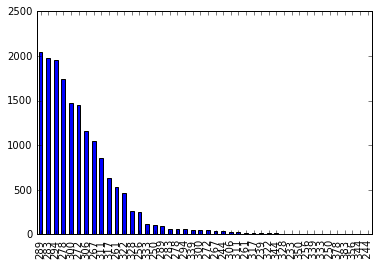

In [51]:
dataset_clean.TMAX.value_counts().plot(kind='bar')
dataset_clean.TMAX.value_counts()

In [59]:
# Variable: TMIN
# Minimum temperature

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on TMIN
dataset_clean["TMIN"].describe()

count     16752
unique       37
top         239
freq       2434
Name: TMIN, dtype: object

239      2434
256      2036
244      2009
250      1948
233      1919
228      1472
261      1348
222      1013
267       701
217       543
211       363
206       199
200        98
  239      79
  250      75
  233      72
  256      60
  244      59
272        56
  228      52
  261      50
  222      37
194        28
  267      23
  217      23
183        13
189        12
  211       8
  206       8
178         3
  272       3
172         2
167         2
  194       1
311         1
-39         1
  200       1
Name: TMIN, dtype: int64

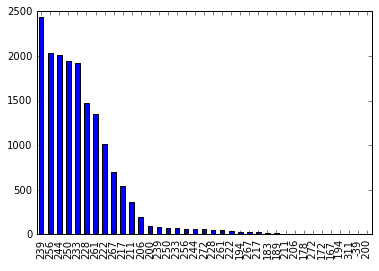

In [60]:
dataset_clean.TMIN.value_counts().plot(kind='bar')
dataset_clean.TMIN.value_counts()

In [53]:
# Variable: PRCP
# Precipitation (mm or inches) 

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on PRCP
dataset_clean["PRCP"].describe()

count     16752
unique      297
top           0
freq       9203
Name: PRCP, dtype: object

0        9203
3        1337
5         829
8         619
10        398
13        386
    0     311
15        292
20        241
18        234
23        206
25        200
28        163
30        154
33        127
36        116
38        106
41         92
51         75
46         73
43         71
48         69
53         50
    3      50
58         48
64         47
56         47
    5      41
61         40
74         38
         ... 
  142       1
589         1
582         1
587         1
   71       1
376         1
  168       1
419         1
  859       1
1687        1
   46       1
315         1
  358       1
   48       1
925         1
1387        1
  185       1
414         1
  175       1
  170       1
996         1
549         1
544         1
546         1
541         1
693         1
772         1
1143        1
1689        1
201         1
Name: PRCP, dtype: int64

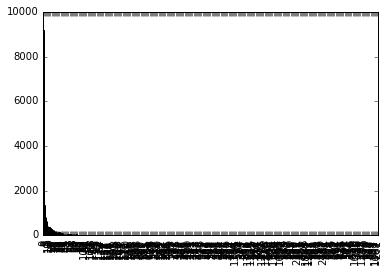

In [54]:
dataset_clean.PRCP.value_counts().plot(kind='bar')
dataset_clean.PRCP.value_counts()

In [55]:
# Variable: SNOW
# Snowfall (mm or inches) 

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on SNOW
dataset_clean["SNOW"].describe()

count     16752
unique        2
top           0
freq      16215
Name: SNOW, dtype: object

0        16215
    0      537
Name: SNOW, dtype: int64

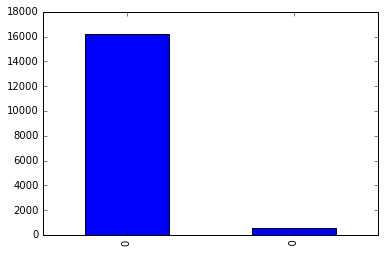

In [56]:
dataset_clean.SNOW.value_counts().plot(kind='bar')
dataset_clean.SNOW.value_counts()
# Wait, what? It doesn't snow in the middle of the Pacific Ocean?

In [57]:
# Variable: SNWD
# Minimum temperature

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on SNWD
dataset_clean["SNWD"].describe()

count     16752
unique        3
top           0
freq      16202
Name: SNWD, dtype: object

0         16202
    0       548
0-9999        2
Name: SNWD, dtype: int64

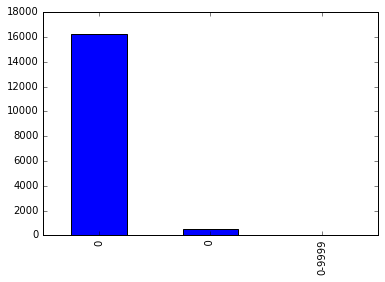

In [58]:
dataset_clean.SNWD.value_counts().plot(kind='bar')
dataset_clean.SNWD.value_counts()
# Drat! More of that '0-9999' value

In [61]:
# Variable: TOBS
# Temperature at the time of observation

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on TOBS
dataset_clean["TOBS"].describe()

count     16752
unique       25
top           0
freq      15929
Name: TOBS, dtype: object

0         15929
250         124
256         119
267         113
244         101
261          97
239          92
233          53
228          41
272          25
217          14
222          11
  261         5
  233         4
  256         4
211           4
  239         3
  267         3
  244         3
  228         2
  250         1
0-9999        1
  217         1
206           1
  272         1
Name: TOBS, dtype: int64

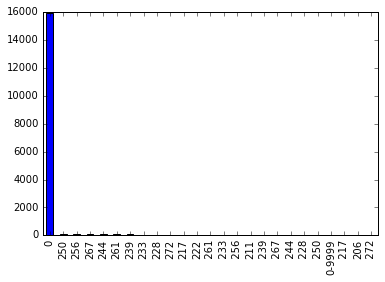

In [62]:
dataset_clean.TOBS.value_counts().plot(kind='bar')
dataset_clean.TOBS.value_counts()

In [63]:
# Variable: WT11
# Weather Type High or damaging winds

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WT11
dataset_clean["WT11"].describe()

count     16752
unique        2
top           0
freq      16751
Name: WT11, dtype: object

0    16751
1        1
Name: WT11, dtype: int64

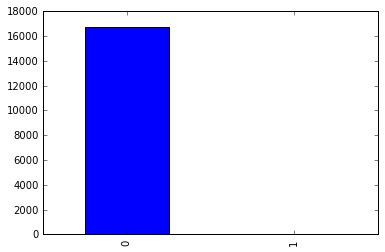

In [64]:
dataset_clean.WT11.value_counts().plot(kind='bar')
dataset_clean.WT11.value_counts()

In [65]:
# Variable: WT03
# Weather Type Thunder

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on TMAX
dataset_clean["WT03"].describe()

count     16752
unique        4
top           0
freq      16666
Name: WT03, dtype: object

0         16666
1            48
0-9999       32
    1         6
Name: WT03, dtype: int64

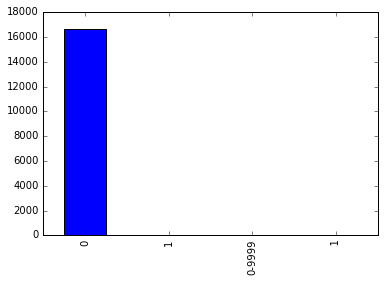

In [66]:
dataset_clean.WT03.value_counts().plot(kind='bar')
dataset_clean.WT03.value_counts()

In [67]:
# Variable: WT01
# Weather Type Fog, ice fog, or freezing fog (may include heavy fog)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WT01
dataset_clean["WT01"].describe()

count     16752
unique        2
top           0
freq      16746
Name: WT01, dtype: object

0    16746
1        6
Name: WT01, dtype: int64

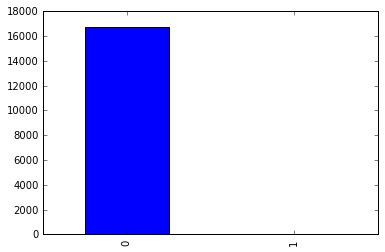

In [68]:
dataset_clean.WT01.value_counts().plot(kind='bar')
dataset_clean.WT01.value_counts()

In [69]:
# Variable: WT16
# Weather Type Rain (may include freezing rain, drizzle, and freezing drizzle)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WT16
dataset_clean["WT16"].describe()

count     16752
unique        4
top           0
freq      13466
Name: WT16, dtype: object

0         13466
1          2994
    1       194
0-9999       98
Name: WT16, dtype: int64

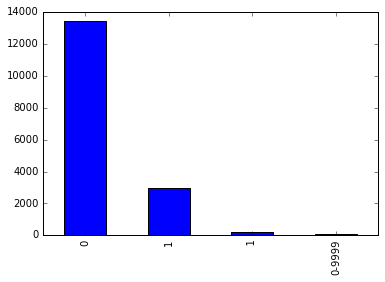

In [70]:
dataset_clean.WT16.value_counts().plot(kind='bar')
dataset_clean.WT16.value_counts()

In [71]:
# Variable: EVAP
# Evaporation of water from evaporation pan

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on EVAP
dataset_clean["EVAP"].describe()

count     16752
unique      128
top           0
freq       9399
Name: EVAP, dtype: object

0        9399
94        355
86        346
99        335
89        335
91        329
81        329
84        327
76        321
102       281
97        279
79        278
74        270
71        267
69        248
66        236
107       211
104       196
109       175
64        171
114       155
61        147
56        131
58        131
112       127
117       100
53         97
51         90
48         78
119        73
         ... 
   36       2
  127       2
   20       2
152         2
155         2
   28       2
163         2
226         1
196         1
193         1
267         1
157         1
   25       1
  122       1
  124       1
   38       1
160         1
165         1
208         1
203         1
15          1
  137       1
  135       1
183         1
170         1
  145       1
241         1
   33       1
   30       1
   43       1
Name: EVAP, dtype: int64

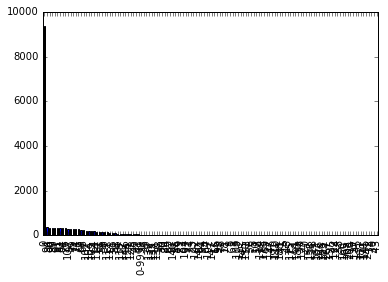

In [72]:
dataset_clean.EVAP.value_counts().plot(kind='bar')
dataset_clean.EVAP.value_counts()

In [73]:
# Variable: WDMV
# 24-hour wind movement (km or miles)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WDMV
dataset_clean["WDMV"].describe()

count     16752
unique      516
top           0
freq       9188
Name: WDMV, dtype: object

0        9188
291        68
282        62
257        61
286        60
332        59
290        59
274        59
328        58
298        58
311        58
336        58
325        57
309        56
264        54
320        53
296        53
354        53
335        52
314        52
317        52
344        51
267        51
327        51
285        51
312        50
261        50
272        49
359        49
319        48
         ... 
542         1
  257       1
  193       1
  256       1
  113       1
  475       1
43          1
42          1
   79       1
45          1
  261       1
555         1
  220       1
  245       1
  365       1
  367       1
618         1
  211       1
  435       1
  431       1
  146       1
  438       1
  148       1
  348       1
806         1
  381       1
  243       1
641         1
550         1
  410       1
Name: WDMV, dtype: int64

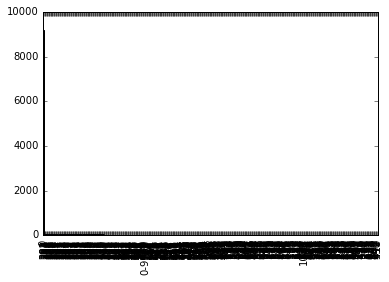

In [74]:
dataset_clean.WDMV.value_counts().plot(kind='bar')
dataset_clean.WDMV.value_counts()

In [75]:
# Variable: WT08
# Weather Type Smoke or haze

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WT08
dataset_clean["WT08"].describe()

count     16752
unique        4
top           0
freq      16726
Name: WT08, dtype: object

0         16726
1            15
0-9999        8
    1         3
Name: WT08, dtype: int64

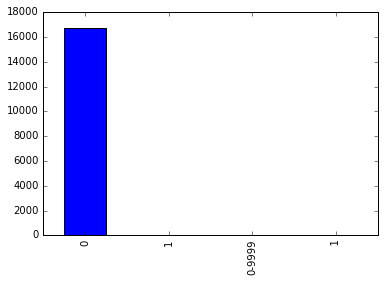

In [76]:
dataset_clean.WT08.value_counts().plot(kind='bar')
dataset_clean.WT08.value_counts()

In [77]:
# Variable: DAEV
# Number of days included in the multiday evaporation total

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on DAEV
dataset_clean["DAEV"].describe()

count     16752
unique        3
top           0
freq      16735
Name: DAEV, dtype: object

0         16735
0-9999        9
2             8
Name: DAEV, dtype: int64

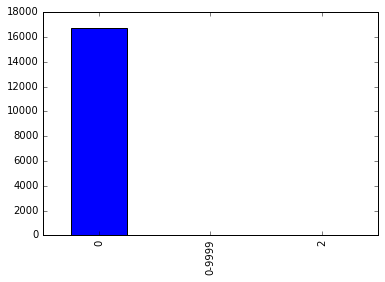

In [78]:
dataset_clean.DAEV.value_counts().plot(kind='bar')
dataset_clean.DAEV.value_counts()

In [79]:
# Variable: DAWM
# Number of days included in the multiday wind movement

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on DAWM
dataset_clean["DAWM"].describe()

count     16752
unique        6
top           0
freq      16733
Name: DAWM, dtype: object

0         16733
2             9
0-9999        7
4             1
9             1
3             1
Name: DAWM, dtype: int64

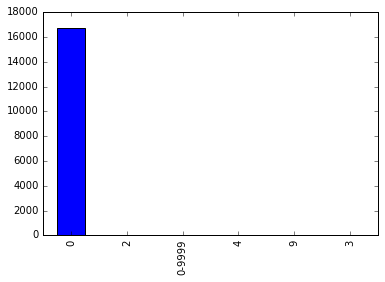

In [80]:
dataset_clean.DAWM.value_counts().plot(kind='bar')
dataset_clean.DAWM.value_counts()

In [81]:
# Variable: MDEV
# Multiday evaporation total (mm or inches)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on MDEV
dataset_clean["MDEV"].describe()

count     16752
unique        9
top           0
freq      16735
Name: MDEV, dtype: object

0         16735
0-9999        9
142           2
152           1
150           1
127           1
84            1
135           1
196           1
Name: MDEV, dtype: int64

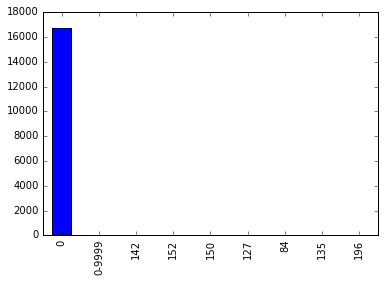

In [82]:
dataset_clean.MDEV.value_counts().plot(kind='bar')
dataset_clean.MDEV.value_counts()

In [83]:
# Variable: MDWM
# Multiday wind movement (miles or km)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on MDWM
dataset_clean["MDWM"].describe()

count     16752
unique       14
top           0
freq      16733
Name: MDWM, dtype: object

0         16733
0-9999        7
892           1
1511          1
360           1
698           1
705           1
491           1
615           1
2229          1
232           1
554           1
745           1
270           1
Name: MDWM, dtype: int64

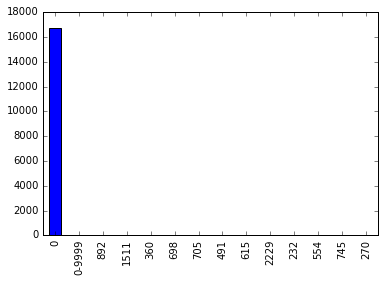

In [84]:
dataset_clean.MDWM.value_counts().plot(kind='bar')
dataset_clean.MDWM.value_counts()

In [85]:
# Variable: MNPN
# Daily minimum temperature of water in an evaporation pan (Fahrenheit or Celsius)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on MNPN
dataset_clean["MNPN"].describe()

count     16752
unique       42
top           0
freq      11677
Name: MNPN, dtype: object

0         11677
228         723
233         674
222         651
211         507
217         467
239         450
206         391
200         363
194         233
244         140
189         117
183          64
250          31
  222        27
178          23
172          22
  233        22
  217        21
  228        20
  239        18
167          16
  211        16
  206        14
161           8
  200         8
  194         7
156           7
0-9999        6
  183         6
256           5
  189         3
  244         3
267           2
  178         2
  167         2
139           1
-50           1
144           1
150           1
 -167         1
261           1
Name: MNPN, dtype: int64

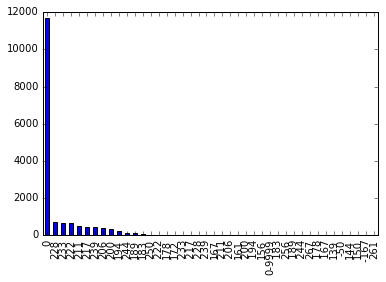

In [86]:
dataset_clean.MNPN.value_counts().plot(kind='bar')
dataset_clean.MNPN.value_counts()

In [87]:
# Variable: MXPN
# Daily maximum temperature of water in an evaporation pan (Fahrenheit or Celsius)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on MXPN
dataset_clean["MXPN"].describe()

count     16752
unique       56
top           0
freq      11724
Name: MXPN, dtype: object

0         11724
333         456
322         430
328         429
311         416
306         353
317         351
339         333
300         302
294         288
289         229
344         226
350         183
283         175
278         155
356         109
272         109
267          67
361          60
367          41
261          36
256          25
250          21
  333        19
  311        17
  328        13
372          13
  289        12
  317        12
  344        11
  322        11
  300        10
  294        10
244           9
233           8
378           8
  283         8
239           8
  356         8
  339         8
0-9999        7
  278         7
  350         7
  306         6
228           4
  256         3
383           3
  267         2
  272         2
217           2
  261         1
406           1
394           1
  367         1
  228         1
411           1
Name: MXPN, dtype: int64

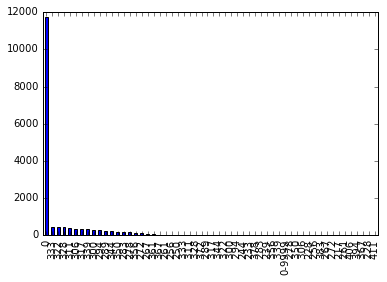

In [88]:
dataset_clean.MXPN.value_counts().plot(kind='bar')
dataset_clean.MXPN.value_counts()

In [89]:
# Variable: ACMH
# Average cloudiness midnight to midnight from manual observations (percent)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on ACMH
dataset_clean["ACMH"].describe()

count     16752
unique       22
top           0
freq      13192
Name: ACMH, dtype: object

0        13192
30         539
40         481
50         420
60         345
20         329
70         320
80         305
90         289
100        226
10          77
   30       46
   40       28
   20       27
   70       26
   50       24
  100       20
   80       20
   60       17
   90       14
   10        6
    0        1
Name: ACMH, dtype: int64

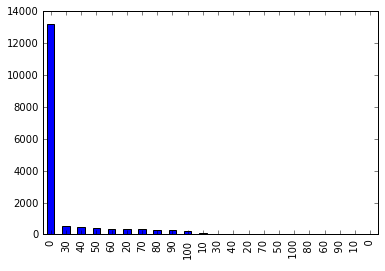

In [90]:
dataset_clean.ACMH.value_counts().plot(kind='bar')
dataset_clean.ACMH.value_counts()
# Unforutnately, not too much cloud cover data is included. And this is what drove us to this data set!

In [91]:
# Variable: ACSH
# Average cloudiness sunrise to sunset from manual observations (percent)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on ACSH
dataset_clean["ACSH"].describe()

count     16752
unique       22
top           0
freq      13050
Name: ACSH, dtype: object

0        13050
30         526
40         465
100        405
50         379
20         378
90         349
70         283
60         279
80         276
10         124
   30       42
  100       36
   20       33
   40       32
   50       22
   60       21
   80       17
   70       16
   90       12
   10        4
    0        3
Name: ACSH, dtype: int64

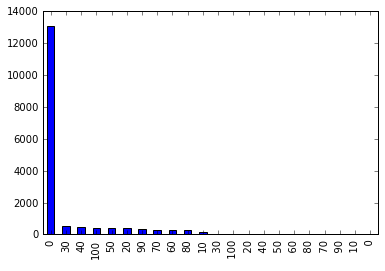

In [92]:
dataset_clean.ACSH.value_counts().plot(kind='bar')
dataset_clean.ACSH.value_counts()

In [93]:
# Variable: PSUN
# Daily percent of possible sunshine (percent)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on PSUN
dataset_clean["PSUN"].describe()

count     16752
unique      172
top           0
freq      13237
Name: PSUN, dtype: object

0        13237
90         123
91         122
92         121
87         119
88         115
86         109
89         107
93         104
83          99
95          98
85          93
94          89
84          87
82          81
79          80
81          73
80          70
78          63
75          58
96          56
73          54
76          54
77          52
97          49
74          48
70          45
71          43
69          42
72          39
         ...  
   78        2
   98        2
   45        2
   60        2
   69        2
   80        2
   26        1
   24        1
    9        1
   66        1
   48        1
    7        1
    5        1
   56        1
   52        1
   15        1
   46        1
   44        1
   43        1
   32        1
   65        1
   31        1
   30        1
   37        1
   35        1
   39        1
  100        1
   68        1
   62        1
   22        1
Name: PSUN, dtype: int64

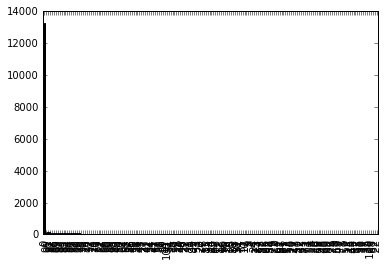

In [94]:
dataset_clean.PSUN.value_counts().plot(kind='bar')
dataset_clean.PSUN.value_counts()

In [95]:
# Variable: TSUN
# Daily total sunshine (minutes)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on TSUN
dataset_clean["TSUN"].describe()

count     16752
unique      330
top           0
freq      13073
Name: TSUN, dtype: object

0        13073
660         88
636         77
624         77
648         77
642         71
696         71
684         71
654         70
690         69
678         68
702         68
618         68
672         68
666         66
630         65
564         65
606         64
594         59
588         59
714         58
576         58
708         55
546         53
600         53
570         52
582         51
534         51
522         50
552         49
         ...  
  561        1
709          1
377          1
613          1
405          1
499          1
682          1
173          1
657          1
650          1
695          1
369          1
   48        1
419          1
  180        1
415          1
549          1
544          1
547          1
691          1
  138        1
661          1
663          1
664          1
665          1
669          1
  450        1
  234        1
   72        1
   24        1
Name: TSUN, dtype: int64

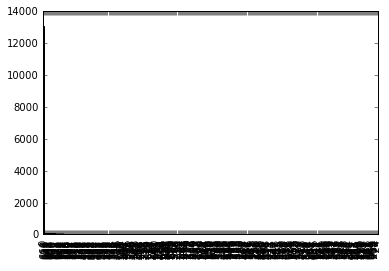

In [96]:
dataset_clean.TSUN.value_counts().plot(kind='bar')
dataset_clean.TSUN.value_counts()

In [97]:
# Variable: WDFM
# Fastest mile wind direction (degrees)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WDFM
dataset_clean["WDFM"].describe()

count     16752
unique       20
top           0
freq      13932
Name: WDFM, dtype: object

0        13932
90        1731
45         477
135        240
   90      114
360         68
180         38
   45       36
68          27
225         20
270         14
315         14
  135       13
113         11
  180        6
  360        4
  225        3
   68        2
  270        1
  315        1
Name: WDFM, dtype: int64

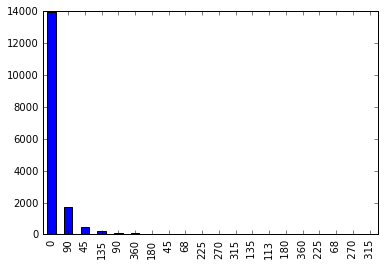

In [98]:
dataset_clean.WDFM.value_counts().plot(kind='bar')
dataset_clean.WDFM.value_counts()

In [99]:
# Variable: WSFM
# Fastest mile wind speed (miles per hour or meters per second)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WSFM
dataset_clean["WSFM"].describe()

count     16752
unique       71
top           0
freq      13932
Name: WSFM, dtype: object

0        13932
116        292
103        180
112        178
98         162
89         159
76         159
107        158
121        139
85         123
125        116
130        113
94         111
80         110
134         96
72          70
143         61
139         53
148         44
67          43
63          40
54          38
152         35
58          34
49          24
  107       19
  121       17
45          17
  103       16
  116       15
         ...  
165          7
   80        7
179          6
  125        6
  134        5
188          5
   63        4
  130        4
  143        3
  152        3
174          3
  139        3
   72        3
   49        2
  148        2
   40        2
197          2
  156        2
   58        2
183          2
   67        2
192          1
   31        1
   54        1
22           1
  210        1
  161        1
469          1
27           1
201          1
Name: WSFM, dtype: int64

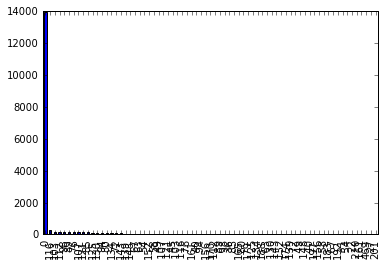

In [100]:
dataset_clean.WSFM.value_counts().plot(kind='bar')
dataset_clean.WSFM.value_counts()

In [101]:
# Variable: PGTM
# Peak gust time (hours and minutes)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on PGTM
dataset_clean["PGTM"].describe()

count     16752
unique      457
top           0
freq      14879
Name: PGTM, dtype: object

0        14879
2354        29
2318        18
0006        18
2348        17
2312        16
0012        16
2230        16
2148        15
2330        15
0000        14
2342        14
2054        13
0018        13
2336        13
1806        13
0700        13
2154        13
2142        12
2218        12
1954        12
2324        12
1136        11
2236        11
1330        11
2118        11
2048        11
0512        11
0030        11
2112        11
         ...  
0128         1
 1406        1
0239         1
0531         1
1009         1
0532         1
 1818        1
0743         1
2108         1
1522         1
 2012        1
 2018        1
 0506        1
1128         1
1651         1
0446         1
 1148        1
2037         1
1927         1
0322         1
0323         1
 0636        1
 0142        1
1013         1
0413         1
0922         1
1600         1
0552         1
0535         1
 0924        1
Name: PGTM, dtype: int64

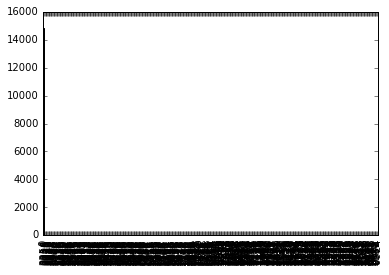

In [102]:
dataset_clean.PGTM.value_counts().plot(kind='bar')
dataset_clean.PGTM.value_counts()

In [103]:
# Variable: WDFG
# Direction of peak wind gust (degrees)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WDFG
dataset_clean["WDFG"].describe()

count     16752
unique       18
top           0
freq      14881
Name: WDFG, dtype: object

0        14881
90        1141
45         379
135        129
   90       78
360         52
   45       26
180         16
270         13
315         12
  135        8
225          6
  360        4
  180        2
  315        2
  270        1
23           1
68           1
Name: WDFG, dtype: int64

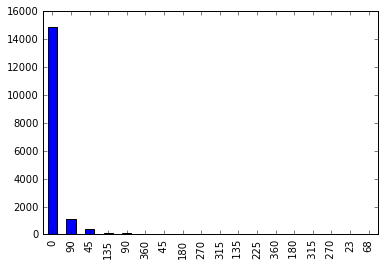

In [104]:
dataset_clean.WDFG.value_counts().plot(kind='bar')
dataset_clean.WDFG.value_counts()

In [105]:
# Variable: WSFG
# Peak guest wind speed (miles per hour or meters per second)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WSFG
dataset_clean["WSFG"].describe()

count     16752
unique       64
top           0
freq      14879
Name: WSFG, dtype: object

0        14879
123        125
113        124
118        122
103        121
108        119
129        113
134        107
139         95
144         87
98          79
149         77
93          76
154         65
87          63
82          54
159         51
164         47
77          41
72          28
67          24
170         23
175         22
180         17
  123       11
62          10
185          9
57           9
  113        9
  139        9
         ...  
  118        8
  129        8
195          7
  134        6
  175        6
200          6
   98        5
  154        5
51           5
211          5
   77        5
  144        5
   87        3
   82        3
206          3
  159        3
41           2
  149        2
  170        2
226          2
   57        2
  164        2
216          2
221          1
236          1
231          1
247          1
  185        1
  180        1
  190        1
Name: WSFG, dtype: int64

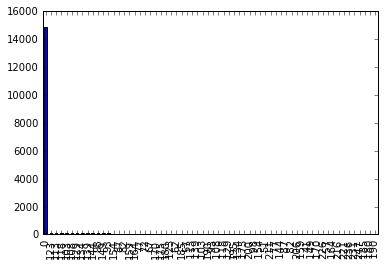

In [106]:
dataset_clean.WSFG.value_counts().plot(kind='bar')
dataset_clean.WSFG.value_counts()

In [107]:
# Variable: WESD
# Water equivalent of snow on the ground (inches or mm)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WESD
dataset_clean["WESD"].describe()

count     16752
unique        1
top           0
freq      16752
Name: WESD, dtype: object

0    16752
Name: WESD, dtype: int64

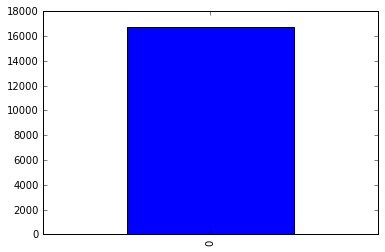

In [108]:
dataset_clean.WESD.value_counts().plot(kind='bar')
dataset_clean.WESD.value_counts()

In [109]:
# Variable: WT05
# Weather Type Hail (may include small hail)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WT05
dataset_clean["WT05"].describe()

count     16752
unique        2
top           0
freq      16751
Name: WT05, dtype: object

0    16751
1        1
Name: WT05, dtype: int64

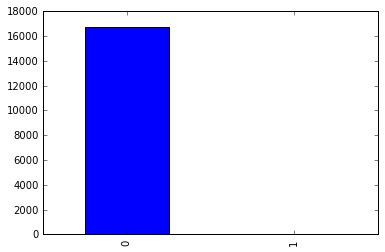

In [110]:
dataset_clean.WT05.value_counts().plot(kind='bar')
dataset_clean.WT05.value_counts()

In [111]:
# Variable: WDF1
# Direction of fastest 1-minute wind (degrees)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WDF1
dataset_clean["WDF1"].describe()

count     16752
unique       48
top           0
freq      15985
Name: WDF1, dtype: object

0        15985
80         153
90         133
70         103
60          88
120         41
50          38
100         35
110         24
40          22
20          13
30          12
   80        9
   70        9
   60        8
   90        8
130          7
10           5
150          4
160          4
140          3
180          3
  100        3
270          3
350          3
280          3
   50        3
360          2
  120        2
330          2
340          2
170          2
  340        2
300          2
220          2
  110        2
320          1
   30        1
240          1
  360        1
  130        1
200          1
310          1
250          1
   10        1
210          1
260          1
   20        1
Name: WDF1, dtype: int64

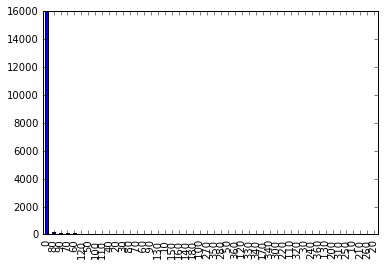

In [112]:
dataset_clean.WDF1.value_counts().plot(kind='bar')
dataset_clean.WDF1.value_counts()

In [113]:
# Variable: WSF1
# Fastest 1-minute wind speed (miles per hour or meters per second)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WSF1
dataset_clean["WSF1"].describe()

count     16752
unique       46
top           0
freq      15985
Name: WSF1, dtype: object

0        15985
94          79
80          65
98          59
76          57
103         56
112         55
72          52
89          51
107         39
63          34
67          32
116         28
130         18
125         18
58          12
54          10
45          10
139         10
134          7
  103        7
143          6
  116        5
   76        5
   89        4
   98        4
156          4
   72        4
   63        4
   67        4
148          3
40           3
  107        3
36           3
   80        3
   45        2
165          2
   94        1
  112        1
  125        1
174          1
27           1
  130        1
  134        1
  143        1
170          1
Name: WSF1, dtype: int64

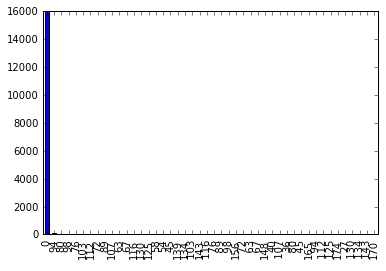

In [114]:
dataset_clean.WSF1.value_counts().plot(kind='bar')
dataset_clean.WSF1.value_counts()

In [115]:
# Variable: AWND
# Average daily wind speed (meters per second or miles per hour)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on AWND
dataset_clean["AWND"].describe()

count     16752
unique       89
top           0
freq      16411
Name: AWND, dtype: object

0        16411
30          29
27          29
22          16
31          16
20          15
23          15
36          15
26          14
28          14
38          13
72           8
76           8
83           6
70           5
67           5
73           5
69           5
59           5
64           5
60           4
81           4
86           3
71           3
45           3
80           3
56           3
82           3
88           3
84           3
         ...  
99           1
109          1
   93        1
32           1
90           1
41           1
   62        1
24           1
44           1
46           1
52           1
57           1
54           1
58           1
   84        1
68           1
65           1
   49        1
74           1
75           1
   76        1
   72        1
   71        1
17           1
   32        1
   31        1
   36        1
   38        1
29           1
   23        1
Name: AWND, dtype: int64

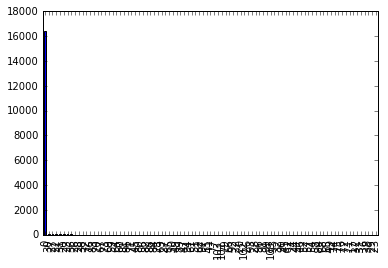

In [116]:
dataset_clean.AWND.value_counts().plot(kind='bar')
dataset_clean.AWND.value_counts()

In [117]:
# Variable: FMTM
# Time of fastest mile or fastest 1-minute wind (hours and minutes)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on FMTM
dataset_clean["FMTM"].describe()

count     16752
unique       35
top           0
freq      16713
Name: FMTM, dtype: object

0        16713
0254         2
0858         2
1256         2
2357         2
0455         2
2151         1
0159         1
1055         1
1053         1
0252         1
 1557        1
0257         1
1953         1
0751         1
0055         1
0056         1
1120         1
2152         1
2056         1
1652         1
2053         1
 2053        1
1049         1
0853         1
0852         1
0854         1
0354         1
0357         1
0452         1
1035         1
0554         1
1552         1
1254         1
 0231        1
Name: FMTM, dtype: int64

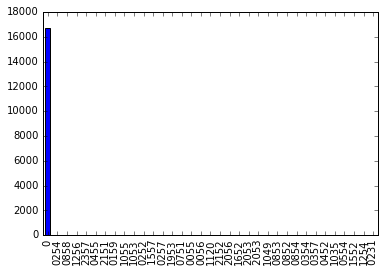

In [118]:
dataset_clean.FMTM.value_counts().plot(kind='bar')
dataset_clean.FMTM.value_counts()

In [119]:
# Variable: WT10
# Weather Type Tornado, waterspout, or funnel cloud

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on WT10
dataset_clean["WT10"].describe()

count     16752
unique        1
top           0
freq      16752
Name: WT10, dtype: object

0    16752
Name: WT10, dtype: int64

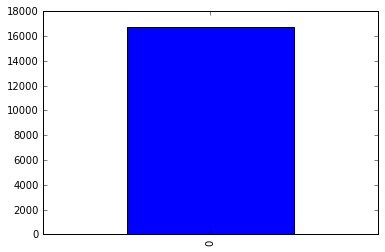

In [120]:
dataset_clean.WT10.value_counts().plot(kind='bar')
dataset_clean.WT10.value_counts()

In [121]:
# Variable: DAPR
# Number of days included in the multiday precipitation total 

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on DAPR
dataset_clean["DAPR"].describe()

count     16752
unique        2
top           0
freq      16751
Name: DAPR, dtype: object

0    16751
3        1
Name: DAPR, dtype: int64

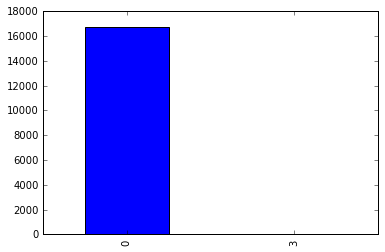

In [122]:
dataset_clean.DAPR.value_counts().plot(kind='bar')
dataset_clean.DAPR.value_counts()

In [123]:
# Variable: MDPR
# Multiday precipitation total (mm or inches)

# Type: Continuous
# Missing values: none (after pre-processing)
# Statistical values on MDPR 
dataset_clean["MDPR"].describe()

count     16752
unique        2
top           0
freq      16751
Name: MDPR, dtype: object

0      16751
178        1
Name: MDPR, dtype: int64

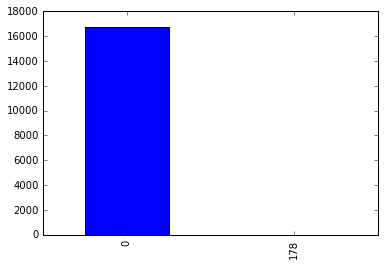

In [124]:
dataset_clean.MDPR.value_counts().plot(kind='bar')
dataset_clean.MDPR.value_counts()

In [132]:
# We still have some pesky '0-9999' characters, likely due to extra padded spacing.
# Ideally, I would go back and include a regular express in the filter, but for now I will take care of these in
# a CSV file:

# Save off the cleaned data:
dataset_clean.to_csv("data_station_JQW00021603_cleanded3.csv")

In [133]:
# After manually removing in Excel, load the data back in:
dataset_clean = pd.read_csv("data_station_JQW00021603_cleanded3.csv")

In [134]:
dataset_clean.head()

,Unnamed: 0,station_code,lat,lon,elev,month,day,TMIN,PRCP,SNOW,...,WSFG,WESD,WT05,WDF1,WSF1,AWND,FMTM,WT10,DAPR,MDPR
0,0,1,16.7333,-169.5167,3,1,1,233,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,16.7333,-169.5167,3,1,3,233,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,1,16.7333,-169.5167,3,1,5,233,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,1,16.7333,-169.5167,3,1,7,233,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,1,16.7333,-169.5167,3,1,9,233,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
# Thank you Excel for adding in a new column:
removeme = dataset_clean.pop("Unnamed: 0")

In [136]:
dataset_clean.head()
# NOTE: I did this manual scub AFTER I already removed the TMAX dependent variable

,station_code,lat,lon,elev,month,day,TMIN,PRCP,SNOW,SNWD,...,WSFG,WESD,WT05,WDF1,WSF1,AWND,FMTM,WT10,DAPR,MDPR
0,1,16.7333,-169.5167,3,1,1,233,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,16.7333,-169.5167,3,1,3,233,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,16.7333,-169.5167,3,1,5,233,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,16.7333,-169.5167,3,1,7,233,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,16.7333,-169.5167,3,1,9,233,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Build the Prediction Model

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math

Our model will be based on the Random Forest.

In [ ]:
# Remove the dependent variable column TMAX, which represents the data we are to be predicting:
y_train = dataset_clean.pop("TMAX") #dataset.pop("TAVG")

In [138]:
# Now, build the TEST and TRAINING data sets:
X_train, X_test, Y_train, Y_test = train_test_split(dataset_clean, y_train, test_size=0.20, random_state=42)

In [139]:
# Check out how many we have to train with:
X_train.shape

(13401, 42)

In [140]:
Y_train.shape

(13401L,)

In [141]:
# Run a Random Forest using parameters previous identified as best on smaller test data:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestClassifier(max_features='sqrt', min_samples_split=1, n_jobs=-1, n_estimators=75, oob_score=True, random_state=42)
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [142]:
print "R^2:", model.score(X_test, Y_test).round(2)

R^2: 0.24


In [143]:
# Here we apply our model:
results = model.predict(X_test)

In [145]:
results

array(['283', '272', '261', ..., '322', '283', '272'], dtype=object)

In [146]:
# Accuracy (the number of correct predictions divided the total number of records):
accuracy = accuracy_score(Y_test, model.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.239629961206


In [147]:
# Precision and Recall:
print classification_report(Y_test, model.predict(X_test))

             precision    recall  f1-score   support

        256       0.00      0.00      0.00         3
        261       0.50      0.17      0.25         6
        267       0.17      0.11      0.13         9
        272       0.20      0.20      0.20        10
        278       0.18      0.19      0.18        16
        283       0.00      0.00      0.00        11
        289       0.28      0.29      0.29        17
        294       0.18      0.11      0.14        18
        300       0.18      0.17      0.17        12
        306       0.00      0.00      0.00         6
        311       0.12      0.25      0.17         4
        317       0.00      0.00      0.00         2
        322       0.00      0.00      0.00         3
        328       0.00      0.00      0.00         1
        333       0.00      0.00      0.00         1
        233       0.00      0.00      0.00         1
        239       0.33      0.33      0.33         3
        244       0.00      0.00      0.00   

C:\Users\mtdea_000\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Analysis and Review

An R^2 score of 0.24 – 24% percent correct prediction of the maximum temperature for a given day of they year based only on the day, scattered measurements of a variety of observations, and the minimum temperature of the day? Maybe not so bad, really.

You could use this model by measuring the lowest temperature during the night and then predicting the maximum temperature that will occur on the same day… and be correct 1 out of 4 days. This might be a match to the success rates of our current TV weather personalities!

I believe a key takeaway here is that there is a lot going on in weather data – it is a very complex fluid with lots of dynamic variables at play – and any predictive model is going to need a lot of specific data. Want to predict tomorrow's weather? You are going to need a lot of data about the recent past. Want to understand climate change? You are going to need a lot of data over a very significant amount of time (how about tens of thousands to millions of years?).

I started out many years ago focusing on complex systems while a graduate student in physics (life took me into an alternate direction, however). So, I have a sense for this notion and it really is a big deal: modeling complex systems is a whole different ballgame, and it takes a broader outlook when it comes to the data feeding into the models. This challenge cannot be underestimated.

The data we have been collecting over the past 50 to 100 hundred years just isn’t thorough enough nor is it accurate enough to hold up in any serious mathematical model of the most massively complex fluid dynamical system we have ever observed and experienced. 

So, let’s all starting collecting more data (come on Citizen Scientists!) and then we can start making better predictions.

# Another Look at the Data

I feel that one of the key challenges of this model is that it was required to predict a specific temperature value – instead of a binary category or range of temperatures. If we instead could just try to predict a temperature range, then the resulting “precision” might be loosened up a bit by offering a broader definition of what is a valid prediction.

So, taking from our family’s repeated experiences at trying to enjoy (not so remote) nearly-tropical islands in the “off-season” of tourism, we have found ourselves spending time in paradise on “not so nice days” (i.e., the temperature was a little too low for comfort and then here comes the afternoon or all-day rain shower).

This being our luck, if I am to ever make the effort to visit such a remote location as Johnston Atoll, then I really would like to make sure that I visit on a “nice day” – it doesn’t have to be a specific temperature, although I would like for the temperature to be relatively “nice”.

What is nice? This will be a personal choice, for sure. For this trial run of a model, we’ll define “nice” as being 27.78 degrees Celcius (a pleasant 85 degrees Fahrenheit). In order to set up this data set, we’ll load back in our sorted and merged measurement data since 1953 and assign a new binary value to any TMAX measurement that is greater than ‘279’.

We set this new binary column to be a “nice day” and we’ll direct our model to try to predict if it will be a nice day or not.

In [13]:
# After manually removing in Excel, load the data back in:
dataset_clean = pd.read_csv("data_station_JQW00021603_cleanded_niceDay.csv")

In [14]:
dataset_clean.head()

,Unnamed: 0,station_code,station,lat,lon,elev,year,month,day,TMAX,...,WSFG,WESD,WT05,WDF1,WSF1,AWND,FMTM,WT10,DAPR,MDPR
0,0,1,JQW00021603,16.7333,-169.5167,3,1953,1,1,278,...,0,0,0,0,0,0,0,0,0,0
1,2,1,JQW00021603,16.7333,-169.5167,3,1953,1,3,283,...,0,0,0,0,0,0,0,0,0,0
2,4,1,JQW00021603,16.7333,-169.5167,3,1953,1,5,272,...,0,0,0,0,0,0,0,0,0,0
3,6,1,JQW00021603,16.7333,-169.5167,3,1953,1,7,272,...,0,0,0,0,0,0,0,0,0,0
4,8,1,JQW00021603,16.7333,-169.5167,3,1953,1,9,278,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Thank you Excel for adding in a new column:
removeme = dataset_clean.pop("Unnamed: 0")

In [16]:
dataset_clean.head()

,station_code,station,lat,lon,elev,year,month,day,TMAX,TMIN,...,WSFG,WESD,WT05,WDF1,WSF1,AWND,FMTM,WT10,DAPR,MDPR
0,1,JQW00021603,16.7333,-169.5167,3,1953,1,1,278,233,...,0,0,0,0,0,0,0,0,0,0
1,1,JQW00021603,16.7333,-169.5167,3,1953,1,3,283,233,...,0,0,0,0,0,0,0,0,0,0
2,1,JQW00021603,16.7333,-169.5167,3,1953,1,5,272,233,...,0,0,0,0,0,0,0,0,0,0
3,1,JQW00021603,16.7333,-169.5167,3,1953,1,7,272,233,...,0,0,0,0,0,0,0,0,0,0
4,1,JQW00021603,16.7333,-169.5167,3,1953,1,9,278,233,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# What is a nice day? How about 85 deg F = 27.78 deg C = 280 in our measurement data file.
count_NiceDay = 0
count = 0
for index, row in dataset_clean.iterrows():
    if (int(float(str(row.TMAX))) > 279):
        count_NiceDay = count_NiceDay + 1
        count = count + 1
    else:
        count = count + 1
print "Total days: " + str(count)
print "Nice days: " + str(count_NiceDay)

Total days: 16752
Nice days: 11391


In [18]:
# Now, we will stransform the TMAX value into this threshold value, where TMAX > 279 = 1, else TMAX = 0
for index, row in dataset_clean.iterrows():
    if (int(float(str(row.TMAX))) > 279):
        dataset_clean.set_value(index, 'TMAX', 1)
    else:
        dataset_clean.set_value(index, 'TMAX', 0)

In [19]:
# Assign this new binary values to a new NICEDAY column:
dataset_clean["NICEDAY"] = dataset_clean["TMAX"]

In [20]:
# Remove the TMAX column, which has been refactored into NICEDAY:
dataset_clean = dataset_clean.drop(['TMAX'], axis=1)

In [21]:
dataset_clean.head()

,station_code,station,lat,lon,elev,year,month,day,TMIN,PRCP,...,WESD,WT05,WDF1,WSF1,AWND,FMTM,WT10,DAPR,MDPR,NICEDAY
0,1,JQW00021603,16.7333,-169.5167,3,1953,1,1,233,0,...,0,0,0,0,0,0,0,0,0,0
1,1,JQW00021603,16.7333,-169.5167,3,1953,1,3,233,0,...,0,0,0,0,0,0,0,0,0,1
2,1,JQW00021603,16.7333,-169.5167,3,1953,1,5,233,0,...,0,0,0,0,0,0,0,0,0,0
3,1,JQW00021603,16.7333,-169.5167,3,1953,1,7,233,0,...,0,0,0,0,0,0,0,0,0,0
4,1,JQW00021603,16.7333,-169.5167,3,1953,1,9,233,0,...,0,0,0,0,0,0,0,0,0,0


1    11391
0     5361
Name: NICEDAY, dtype: int64

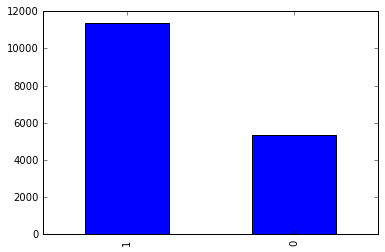

In [22]:
# A little EDA on our new NICEDAY:
dataset_clean.NICEDAY.value_counts().plot(kind='bar')
dataset_clean.NICEDAY.value_counts()

In [157]:
# We don't need the station name as we included unique single digit number during pre-processing
# to represent the station (NOTE: I added this in the pre-processing because once I made it here in earlier testing
# the model crashed out when it looked at the character values in the station ID)
station_names = dataset_clean.pop("station")
# We don't need the year, since we are just trying to predict the maximum temperature on a particular day of the year
all_years = dataset_clean.pop("year")

In [158]:
# Remove the dependent variable column NICEDAY, which represents the data we are to be predicting:
y_train = dataset_clean.pop("NICEDAY")

In [159]:
# Now, build the TEST and TRAINING data sets:
X_train, X_test, Y_train, Y_test = train_test_split(dataset_clean, y_train, test_size=0.20, random_state=42)

In [160]:
# Check out how many we have to train with:
X_train.shape

(13401, 42)

In [161]:
Y_train.shape

(13401L,)

In [162]:
# Run a Random Forest using parameters previous used:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestClassifier(max_features='sqrt', min_samples_split=1, n_jobs=-1, n_estimators=75, oob_score=True, random_state=42)
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=1,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [163]:
print "R^2:", model.score(X_test, Y_test).round(2)

R^2: 0.83


In [164]:
# Here we apply our model:
results = model.predict(X_test)

In [165]:
results

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

In [166]:
# Accuracy (the number of correct predictions divided the total number of records):
accuracy = accuracy_score(Y_test, model.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.833780960907


In [167]:
# Precision and Recall:
print classification_report(Y_test, model.predict(X_test))

             precision    recall  f1-score   support

          0       0.77      0.69      0.73      1075
          1       0.86      0.90      0.88      2276

avg / total       0.83      0.83      0.83      3351



In [168]:
# Let's try to improve this with a grid search:
# Run Grid Search on a Random Forest model to optimize:
n_estimators = [100,400,500]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [3,5,7]

rfc = RandomForestClassifier(n_jobs=1)
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [169]:
# Run the training data through the optimization:
estimator.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 7], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [100, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [170]:
# Output the best parameters for the training data:
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [171]:
# Note: split = 7, estimators = 400
# Store this classifier's parameters:
best_rfc = estimator.best_estimator_

In [172]:
# Run a Random Forest using parameters previous identified as best:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestClassifier(max_features='sqrt', min_samples_split=7, n_jobs=1, n_estimators=400, oob_score=False, random_state=42)
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [173]:
print "R^2:", model.score(X_test, Y_test).round(2)

R^2: 0.84


In [174]:
# Accuracy (the number of correct predictions divided the total number of records):
accuracy = accuracy_score(Y_test, model.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.839749328559


In [175]:
# Precision and Recall:
print classification_report(Y_test, model.predict(X_test))

             precision    recall  f1-score   support

          0       0.78      0.69      0.73      1075
          1       0.86      0.91      0.89      2276

avg / total       0.84      0.84      0.84      3351



# Final Review

With an R^2 score of 84%, we seem to have improved our weather prediction quite a bit. Of course, we generalized – significantly – what we were trying to predict, so in this sense, it certainly isn’t as difficult to make a “reasonable” guess as to if it will be a nice day or not on Johnston Atoll. On the other hand, this prediction is based on scattered weather measurements taken for more than 50 years tied together primarily by the particular day of the year. So, that does still seem rather interesting: we can take any day of the year and make a “reasonable” guess – within 84% -- as to if it will be a nice day or not.

For my own family’s future travel planning, this model will prove to be extremely valuable!